In [77]:
import requests
import json
import time
from bs4 import BeautifulSoup
import os
import csv
import re

# constant
ARTICLE_ID = 'article_id'
SECTION_ID = 'section_id'
SUB_SECTION_ID = 'sub_section_id'
NEWSPAPER_ID = 'newspaper_id'
NEWSPAPER_NAME = 'newspaper_name'
TITLE = 'title'
JOURNALIST_NAME = 'journalist_name'
CREATED_AT = 'created_at'
UPDATED_AT = 'updated_at'
CONTENT_ORIGIN = 'content_origin'
CONTENT_TEXT = 'content_text'

#TODO: 이슈사항 - 해당 정보들은 js가 완전 로드된 후 크롤링 진행 필요 -> selenium으로 처리
COMMENT_TOTAL_COUNT = 'comment_total_count' # TODO
COMMENT_CURRENT_COUNT = 'comment_current_count' # TODO
COMMENT_DELETED_COUNT = 'comment_deleted_count' # TODO
COMMENT_DELETED_COUNT = 'comment_deleted_count' # TODO
LIKE_TOTAL_COUNT = 'like_total_count'           # TODO
LIKE_USEFUL_COUNT = 'like_useful_count'         # TODO # 쏠쏠정보
LIKE_WOW_COUNT = 'like_wow_count'               # TODO # 흥미진진
LIKE_TOUCHED_COUNT = 'like_touched_count'       # TODO # 공감백배
LIKE_ANALYTICAL_COUNT = 'like_analytical_count' # TODO # 분석탁월
LIKE_RECOMMEND_COUNT = 'like_recommend_count'   # TODO # 후속강추


def init_article_data():
    return {
        ARTICLE_ID: None,
        SECTION_ID: None,
        SUB_SECTION_ID: None,
        NEWSPAPER_ID: None,
        NEWSPAPER_NAME: None,
        TITLE: None,
        JOURNALIST_NAME: None,
        CREATED_AT: None,
        UPDATED_AT: None,
        CONTENT_ORIGIN: None,
        CONTENT_TEXT: None,
        # COMMENT_TOTAL_COUNT: None,
        # COMMENT_CURRENT_COUNT: None,
        # COMMENT_DELETED_COUNT: None
        # LIKE_TOTAL_COUNT: None,
        # LIKE_USEFUL_COUNT: None,
        # LIKE_WOW_COUNT: None,
        # LIKE_TOUCHED_COUNT: None,
        # LIKE_ANALYTICAL_COUNT: None,
        # LIKE_RECOMMEND_COUNT: None,
    }

def extract_comment_count(newspaper_id, article_id):
    base_url = "https://n.news.naver.com/mnews/article/comment/"
    url = f"{base_url}/{newspaper_id}/{article_id}"
    
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

def extract_url_ids(url):
    match = re.search(r'/article/(\d+)/(\d+)', url)
    if match:
        newspaper_id = match.group(1)
        article_id = match.group(2)
        return newspaper_id, article_id
    else:
        return None, None

def extract_article_data(section_id, sub_section_id, url): 
    article_data = init_article_data()
    
    # HTTP 요청 보내기
    response = requests.get(url)

    # 신문사 ID, 기사 ID
    article_data[SECTION_ID], article_data[SUB_SECTION_ID] = section_id, sub_section_id
    article_data[NEWSPAPER_ID], article_data[ARTICLE_ID] = extract_url_ids(url)
    
    # HTML 파싱
    soup = BeautifulSoup(response.text, 'html.parser')

    # 신문사
    newspaper_node = soup.find('meta', {'name': 'twitter:creator'})
    article_data[NEWSPAPER_NAME] = newspaper_node.get('content') if newspaper_node else None
    
    # 기사 제목 추출
    title_node = soup.find('h2', {'id': 'title_area'})
    article_data[TITLE] = title_node.text.strip() if title_node else None
    
    # 입력일자 추출
    created_at_node = soup.find('span', {'class': 'media_end_head_info_datestamp_time _ARTICLE_DATE_TIME'})
    article_data[CREATED_AT] = created_at_node.get('data-date-time') if created_at_node else None
    
    
    # 수정일자 추출
    updated_at_node = soup.find('span', {'class': 'media_end_head_info_datestamp_time _ARTICLE_MODIFY_DATE_TIME'})
    article_data[UPDATED_AT] = updated_at_node.get('data-modify-date-time') if updated_at_node else None

    # 기자명
    journalist_node = soup.find('em', {'class', 'media_end_head_journalist_name'})
    article_data[JOURNALIST_NAME] = journalist_node.text.strip() if journalist_node else None
    
    # 기사 내용 추출
    content_node = soup.find('article', {'id': 'dic_area'})
    article_data[CONTENT_TEXT] = content_node.text.strip() if content_node else None
    article_data[CONTENT_ORIGIN] = content_node if content_node else None

    # 댓글 수
    # comment_total_node = soup.find('span', {'class': 'u_cbox_head'})
    # article_data[COMMENT_TOTAL_COUNT] = comment_total_node.text.strip()

    # 좋아요 수
    # like_total_node = soup.find('span', {'class':"u_likeit_text _count num"})
    # article_data[LIKE_TOTAL_COUNT] = like_total_node.text.strip()
    # like_useful_node = soup.find('li', {'class':"u_likeit_list useful"}).find('span', 'u_likeit_list_count _count')
    # article_data[LIKE_USEFUL_COUNT] = like_useful_node.text.strip()
    # like_wow_node = soup.find('li', {'class':"u_likeit_list wow"}).find('span', 'u_likeit_list_count _count')
    # article_data[LIKE_WOW_COUNT] = like_wow_node.text.strip()
    # like_touched_node = soup.find('li', {'class':"u_likeit_list touched"}).find('span', 'u_likeit_list_count _count')
    # article_data[LIKE_TOUCHED_COUNT] = like_touched_node.text.strip()
    # like_analytical_node = soup.find('li', {'class':"u_likeit_list analytical"}).find('span', 'u_likeit_list_count _count')
    # article_data[LIKE_ANALYTICAL_COUNT] = like_analytical_node.text.strip()
    # like_recommend_node = soup.find('li', {'class':"u_likeit_list recommend"}).find('span', 'u_likeit_list_count _count')
    # article_data[LIKE_RECOMMEND_COUNT] = like_recommend_node.text.strip()
    

    return article_data

def load_article_list(section_id, sub_section_id, data_cursor):
    # 요청할 URL
    url = f'https://news.naver.com/section/template/SECTION_ARTICLE_LIST_FOR_LATEST?sid={section_id}&sid2={sub_section_id}&cluid=&pageNo=1&date=&next={data_cursor}'
    
    # HTTP GET 요청을 보내고 응답을 받음
    response = requests.get(url)
    
    # 요청이 성공적으로 이루어졌는지 확인 (상태 코드가 200인 경우)
    if response.status_code == 200:
        # JSON 데이터 파싱
        json_data = response.json()
    
        # renderedComponent 내에서 SECTION_ARTICLE_LIST 추출
        try:
            rendered_component = json_data['renderedComponent']
            section_article_list_html = rendered_component.get('SECTION_ARTICLE_LIST_FOR_LATEST', '')
    
            # SECTION_ARTICLE_LIST의 값이 HTML이면 BeautifulSoup으로 파싱
            if section_article_list_html:
                soup = BeautifulSoup(section_article_list_html, 'html.parser')
                
                next_div = soup.find('div', {'data-cursor-name': 'next'})
                next_data_cusor = next_div.get("data-cursor")
                
                # "https://n.news.naver.com/mnews/article/{id}/{id}" 형식의 URL만 필터링 (id는 숫자와 문자가 섞인 형식)
                href_list = list({
                    a.get('href').replace("\\", "").replace("\"", "")
                    for a in soup.find_all('a', href=True)
                    if re.search(r'https://n\.news\.naver\.com/mnews/article/\d{3}/\d+', a.get('href'))
                })
                
                # URL 리스트 정렬
                href_list.sort()

                return (next_data_cusor, href_list)
    
            else:
                print("ERROR>>> SECTION_ARTICLE_LIST_FOR_LATEST 내용이 없습니다.")
        except KeyError as e:
            print(f"ERROR>>> '{e}' 키를 찾을 수 없습니다.")
    else:
        print(f"ERROR>>> Failed to retrieve the page. Status code: {response.status_code}")

def save(section_id, sub_section_id, file_id, data=[]):
    # CSV 파일 경로
    directory = "./data"
    save_file_name = f"article_{section_id}_{sub_section_id}_{file_id}.csv"
    save_file_path = os.path.join(directory, save_file_name)
    
    # 필드 이름 (헤더)
    # TODO: 최신화
    field_names = [ARTICLE_ID, SECTION_ID, SUB_SECTION_ID, NEWSPAPER_ID, NEWSPAPER_NAME, TITLE, JOURNALIST_NAME, CREATED_AT, UPDATED_AT, CONTENT_ORIGIN, CONTENT_TEXT]

    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # CSV 파일 작성 및 데이터 추가
    file_exists = os.path.exists(save_file_path)
    
    # 파일 쓰기 모드
    with open(save_file_path, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=field_names)
    
        # 파일이 없으면 헤더 추가
        if not file_exists:
            writer.writeheader()
    
        # 데이터 추가
        for row in data:
            writer.writerow(row)

def get_next_data_cursor(section, data_cursor):
    url = f'https://news.naver.com/section/template/SECTION_ARTICLE_LIST_FOR_LATEST?sid={section[SECTION_ID]}&sid2={section[SUB_SECTION_ID]}&cluid=&pageNo=1&date=&next={data_cursor}'
    # HTTP GET 요청을 보내고 응답을 받음
    response = requests.get(url)
    
    # 요청이 성공적으로 이루어졌는지 확인 (상태 코드가 200인 경우)
    if response.status_code == 200:
        # JSON 데이터 파싱
        json_data = response.json()
    
        # renderedComponent 내에서 SECTION_ARTICLE_LIST 추출
        try:
            rendered_component = json_data['renderedComponent']
            section_article_list_html = rendered_component.get('SECTION_ARTICLE_LIST_FOR_LATEST', '')
    
            # SECTION_ARTICLE_LIST의 값이 HTML이면 BeautifulSoup으로 파싱
            if section_article_list_html:
                soup = BeautifulSoup(section_article_list_html, 'html.parser')
                
                next_div = soup.find('div', {'data-cursor-name': 'next'})
                next_data_cusor = next_div.get("data-cursor")
                
                return next_data_cusor
    
            else:
                print("ERROR>>> SECTION_ARTICLE_LIST_FOR_LATEST 내용이 없습니다.")
        except KeyError as e:
            print(f"ERROR>>> '{e}' 키를 찾을 수 없습니다.")
    else:
        print(f"ERROR>>> Failed to retrieve the page. Status code: {response.status_code}")


In [78]:
# 위에서부터 중요도 순으로 정렬되어 있음

sections = {
    "부동산": {SECTION_ID: "101", SUB_SECTION_ID: "260"},
    "금융": {SECTION_ID: "101", SUB_SECTION_ID: "259"},
    "증권": {SECTION_ID: "101", SUB_SECTION_ID: "258"},
    "생활경제": {SECTION_ID: "101", SUB_SECTION_ID: "310"},
    "경제 일반": {SECTION_ID: "101", SUB_SECTION_ID: "263"},
    "행정": {SECTION_ID: "100", SUB_SECTION_ID: "266"},
    "정치일반": {SECTION_ID: "100", SUB_SECTION_ID: "269"},
    "산업/재계": {SECTION_ID: "101", SUB_SECTION_ID: "261"},
    "중기/벤처": {SECTION_ID: "101", SUB_SECTION_ID: "771"},
    "글로벌 경제": {SECTION_ID: "101", SUB_SECTION_ID: "262"},
    "대통령실": {SECTION_ID: "100", SUB_SECTION_ID: "264"},
    "국회/정당": {SECTION_ID: "100", SUB_SECTION_ID: "265"},
    "북한": {SECTION_ID: "100", SUB_SECTION_ID: "268"},
    "국방/외교": {SECTION_ID: "100", SUB_SECTION_ID: "267"},
}

In [79]:
# 실제 실행 코드

section = sections.get("행정") # 크롤링할 섹션 지정
data_cursor='' # 중단 후 이어서 진행 시 data_cursor 갑 지정
while(data_cursor=='' or data_cursor >= '2024112300000000000'): # 기한 지정
    print(f"start loading {data_cursor}...")
    data_cursor, href_list = load_article_list(section[SECTION_ID], section[SUB_SECTION_ID], data_cursor)
    print(f"Complete loading {data_cursor} successfully!")
    article_data_list = []
    for url in href_list:
        print(f"Start extracting {url}...")
        article_data_list.append(extract_article_data(section[SECTION_ID], section[SUB_SECTION_ID], url))
        print(f"Complete extracting Successfully!")
        time.sleep(1)
    print(f"Save data... file_id: {data_cursor}")
    save(section[SECTION_ID], section[SUB_SECTION_ID], data_cursor, article_data_list)
    print(f"Saved.")

start loading ...
Complete loading 2024112412000020725 successfully!
Start extracting https://n.news.naver.com/mnews/article/001/0015063648...
Complete extracting Successfully!
Start extracting https://n.news.naver.com/mnews/article/001/0015063702...
Complete extracting Successfully!
Start extracting https://n.news.naver.com/mnews/article/001/0015063773...
Complete extracting Successfully!
Start extracting https://n.news.naver.com/mnews/article/001/0015063805...
Complete extracting Successfully!
Start extracting https://n.news.naver.com/mnews/article/001/0015064024...
Complete extracting Successfully!
Start extracting https://n.news.naver.com/mnews/article/001/0015064244...
Complete extracting Successfully!
Start extracting https://n.news.naver.com/mnews/article/001/0015064245...
Complete extracting Successfully!
Start extracting https://n.news.naver.com/mnews/article/001/0015064246...
Complete extracting Successfully!
Start extracting https://n.news.naver.com/mnews/article/001/0015064

# data cursor 값 확인 방법
1. 마지막 data cursor 로그 확인
   - print(f"start loading {data_cursor}...")
   - 사진 예> data cursor: 2024112416451472100   
     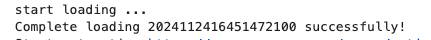
2. 다음 코드 실행

In [74]:
# data cursor 값 확인 코드
section = sections.get("중기/벤처") # 크롤링할 섹션 지정
data_cursor= 2024112416451472100
get_next_data_cursor(section, data_cursor)

'2024112412000005185'

In [57]:
# test
section = sections.get('증권')
extract_article_data(section_id=section[SECTION_ID], sub_section_id=section[SUB_SECTION_ID], url='https://n.news.naver.com/mnews/article/009/0005401979')

{'article_id': '0005401979',
 'newspaper_id': '009',
 'newspaper_name': '매일경제',
 'title': '테슬라·팰런티어 임원들 美증시 랠리에 자사주 팔아',
 'journalist_name': '김인오 기자',
 'created_at': '2024-11-24 17:54:07',
 'updated_at': None,
 'content_origin': <article class="go_trans _article_content" id="dic_area">
 <span style="border-left:4px solid #959595; padding-left: 20px; display: inline-block"><strong>고점에 이익 실현 나선듯<br/>美임원 자사주 매도 최대</strong></span><br/><br/>미국 대표 주가 지수인 스탠더드앤드푸어스(S&amp;P) 500이 연일 사상 최고가를 갈아 치우며 상승세를 이어가고 있다. 이런 가운데 주요 기업 경영진의 자사주 매도 비율이 올해 4분기 들어 역대 최대치에 달했다는 분석이 나와 이목이 쏠린다.<br/><br/>23일(현지시간) 미국 금융정보 데이터 업체인 베리티데이터의 집계에 따르면 S&amp;P500 지수에 포함된 기업 내부자들의 자사주 매수 대비 매도 비율이 4분기 들어 23.7을 기록했다. 집계가 시작된 2004년 이후 분기별 평균치(12)를 훌쩍 웃도는 수준이다.<br/><br/>대표적인 사례가 팰런티어와 테슬라다. 한국인 순매수 인기 종목인 팰런티어의 알렉산더 카프 최고경영자(CEO)는 지난 7~22일 내부자 거래 규정 중 하나인 '10b5-1' 거래 계획을 통해 자사주를 총 8억1596만달러(약 1조1468억원)어치 내다 팔았다.<br/><br/>테슬라의 경우 캐슬린 윌슨톰프슨 이사와 로빈 덴홈 회장이 10b5-1 계획에 따라 주식매수선택권(스톡옵션) 행사를 통해 이달 들어 약 7000만달러어치 자사주를 내다 팔았다. 윌슨톰프